<a href="https://colab.research.google.com/github/ViniciusCastillo/Test_Einstein/blob/main/notebooks/Classification_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification test
In this notebook I will analysis the dataset and try to find the better classification model to predict the target variable


In [106]:
# import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import sqrt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from joblib import dump
# configur number display format
pd.options.display.float_format = "{:,.4f}".format

## Functions

In [83]:
def roc_auc_score_multi (model, X, y): 
  """ 
  Function to calculate the ROC AUC
  ________________________________________________________________________________________________________________
    INPUT
    ----------
    model: scikit learn model
      a fit classificer model
    X: DataFrame 
      samples to test the model
    y: Series
      the test target
    ________________________________________________________________________________________________________________
    OUTPUT
    ------
    Float: ROC AUC of the model

  """
  return roc_auc_score(y_true=y, y_score=model.predict_proba(X), multi_class='ovo')

def test_model (model, X, y, params, model_name=None, n_splits=5, n_repeats=10):
  """ 
  Function to find de best parameters combination of the model
  ________________________________________________________________________________________________________________
    INPUT
    ----------
    model: scikit learn model
      a classificer model to find de best parameters
    X: DataFrame 
      samples to train the model
    y: Series
      the train target
    params: dict
      parameters to find de best using GridSearchCV
    model_name: string (default=None)
      name to use in prints of this function if you want
    n_splits: int (default=5)
      number of splits to the Cross Validation using RepeatedStratifiedKfold
    n_repeates: int (default=5)
      number of repeates to the Cross Validation using RepeatedStratifiedKfold
    ________________________________________________________________________________________________________________
    OUTPUT
    ------
    DataFrame: DataFrame with the results of each parameters combination sorted by the ROC AUC

  """
  cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats)
  grid = GridSearchCV(model, params, scoring=roc_auc_score_multi, cv=cv).fit(X,y)
  result_itens = ['rank_test_score','mean_test_score']
  result_itens.extend([item for item in pd.DataFrame(grid.cv_results_).columns.values if "param_" in item])
  results = pd.DataFrame(grid.cv_results_)[result_itens]
  
  print('Best', model_name,':\n', results.sort_values(by='rank_test_score').iloc[0,1:], '\n\n')

  return results.sort_values(by='rank_test_score')

def test_model_select (ns_select, model, X, y, params, model_name=None, n_splits=5, n_repeats=10):
  """ 
  Function to find de best parameters combination of the model and the best selection of variables
  ________________________________________________________________________________________________________________
    INPUT
    ----------
    ns_select: list of ints
      list with the number of selections to test in the SelectKBest
    model: scikit learn model
      a classificer model to find de best parameters
    X: DataFrame 
      samples to train the model
    y: Series
      the train target
    params: dict
      parameters to find de best using GridSearchCV
    model_name: string (default=None)
      name to use in prints of this function if you want
    n_splits: int (default=5)
      number of splits to the Cross Validation using RepeatedStratifiedKfold
    n_repeates: int (default=5)
      number of repeates to the Cross Validation using RepeatedStratifiedKfold
    ________________________________________________________________________________________________________________
    OUTPUT
    ------
    DataFrame: DataFrame with the results of each parameters combination sorted by the ROC AUC

  """
  best = [0, 0]
  for n in ns_select:
    X_sel = SelectKBest(k=n).fit_transform(X, y)
    print(f'{n} FEATURES SELECT\n')
    result = test_model (model=model, X=X_sel, y=y, params=params, model_name=model_name, n_splits=n_splits, n_repeats=n_repeats)
    result['n'] = n
    if best[0] == 0:
      results = result
    else:
      results = pd.concat([results,result])

    if float(result.mean_test_score.loc[result['rank_test_score'] == 1].head(1)) > best[1]:
      best = [n, float(result.mean_test_score.loc[result['rank_test_score'] == 1].head(1))]
    
  results = results.sort_values(by='mean_test_score', ascending=False).reset_index(drop=True)

  print(f'\nBest Selection:\n{results.n[0]} features. ROC AUC: {results.mean_test_score[0]:.4f}\n\n')
  return results.head(10)

def fit_test_results (model, X_train, y_train, X_test, y_test, model_name=None):
  """ 
  Function to calculate print results of the model and return the model fited
  ________________________________________________________________________________________________________________
    INPUT
    ----------
    model: scikit learn model
      a classificer model
    X_train: DataFrame 
      samples to train the model
    y_train: Series
      the train target
    X_test: DataFrame 
      samples to test the model
    y_test: Series
      the test target
    model_name: string (default=None)
      name to use in prints of this function if you want
    ________________________________________________________________________________________________________________
    OUTPUT
    ------
    model: classifier model fited

  """
  model = model.fit(X_train, y_train)
  print(f'model: {model_name}')
  print('\n Classification Report: \n', classification_report(y_test, model.predict(X_test)))
  print(f'\n ROC AUC  Score: {roc_auc_score_multi(model, X_test, y_test):.4f}\n\n')
  return model

## Data analysis 

In [107]:
# import dataset
df = pd.read_csv('https://github.com/ViniciusCastillo/Teste_Einstein/raw/main/datasets/data.csv')
# view formats e size
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      10000 non-null  float64
 1   x2      10000 non-null  float64
 2   x3      10000 non-null  float64
 3   target  10000 non-null  object 
dtypes: float64(3), object(1)
memory usage: 312.6+ KB


In [108]:
# view some stats of the dataset
df.describe(include='all')

,x1,x2,x3,target
count,"10,000.0000","10,000.0000","10,000.0000",10000
unique,NaN,NaN,NaN,3
top,NaN,NaN,NaN,low
freq,NaN,NaN,NaN,6000
mean,42.6696,9.0232,-24.6032,NaN
std,25.5978,5.1802,20.1386,NaN
min,-19.5000,0.1700,-59.9800,NaN
25%,21.6750,5.2600,-41.9200,NaN
50%,42.9400,8.0750,-24.5550,NaN
75%,64.1350,11.7300,-7.0800,NaN


In [109]:
# view with de target is balanced
df.target.value_counts().to_frame()

,target
low,6000
high,3000
med,1000


we can see the target is inbalanced and we will need to treat this before training the models

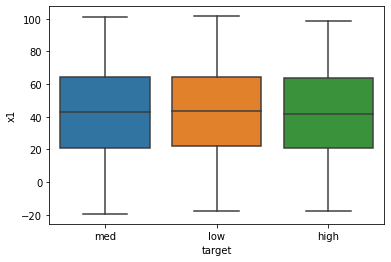

In [110]:
# view the distribution of x1 by target
sns.boxplot(y=df['x1'], x=df['target'])

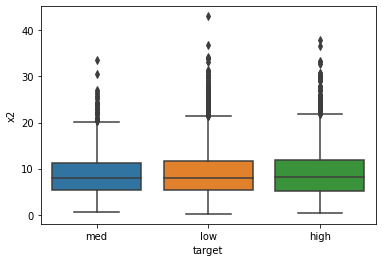

In [111]:
# view the distribution of x2 by target
sns.boxplot(y=df['x2'], x=df['target'])

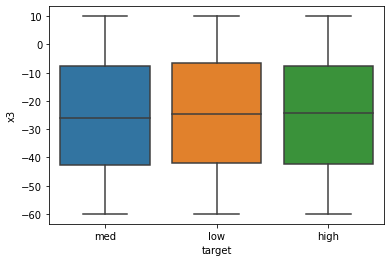

In [112]:
# view the distribution of x3 by target
sns.boxplot(y=df['x3'], x=df['target'])

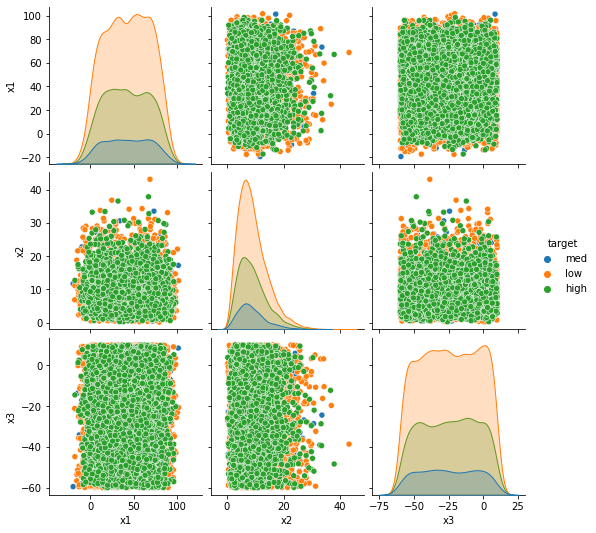

In [113]:
# plot a pairplot to confirm what we have seen before on boxplots, we don't have any correlation between target and features
sns.pairplot(df, hue='target')

we don't have any correlation between target and features, and I will create some other features to try have a better model.

also, we can see the features will need to be rescale too, to guarantee a better fit on model.

another thing, I don´t go to treat de outliers because in this case I don't think this will create a grate problem to the model


In [114]:
# add features manipulating the original ones
df['x13'] = df['x1']/df['x3']
df['x23'] = df['x2']/df['x3']
df['x12'] = df['x1']/df['x2']
df['x1^2'] = df['x1']**2
df['x2^2'] = df['x2']**2
df['x3^2'] = df['x3']**2
df['x1^3'] = df['x1']**3
df['x2^3'] = df['x2']**3
df['x3^3'] = df['x3']**3
df['log(x1-min(x1)+1)'] = (df['x1']-df['x1'].min()+1).transform(np.log)
df['log(x2-min(x2)+1)'] = (df['x2']-df['x2'].min()+1).transform(np.log)
df['log(x3-min(x3)+1)'] = (df['x3']-df['x3'].min()+1).transform(np.log)
df.describe()

,x1,x2,x3,x13,x23,x12,x1^2,x2^2,x3^2,x1^3,x2^3,x3^3,log(x1-min(x1)+1),log(x2-min(x2)+1),log(x3-min(x3)+1)
count,"10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000"
mean,42.6696,9.0232,-24.6032,inf,inf,7.2286,"2,475.8802",108.2501,"1,010.8393","161,189.0132","1,614.7412","-45,026.3697",4.0428,2.1484,3.3392
std,25.5978,5.1802,20.1386,NaN,NaN,10.3192,"2,264.3881",130.1708,"1,065.0106","190,488.6713","3,299.2364","59,111.5780",0.4903,0.5457,0.8520
min,-19.5000,0.1700,-59.9800,"-7,408.0000",-635.0000,-5.5574,0.0000,0.0289,0.0000,"-7,414.8750",0.0049,"-215,784.0720",0.0000,0.0000,0.0000
25%,21.6750,5.2600,-41.9200,-2.4707,-0.5224,2.3449,469.8057,27.6676,72.4201,"10,183.0418",145.5316,"-73,665.4459",3.7418,1.8066,2.9476
50%,42.9400,8.0750,-24.5550,-1.2042,-0.2391,4.9164,"1,843.8437",65.2057,602.9480,"79,174.6571",526.5360,"-14,805.3906",4.1501,2.1866,3.5953
75%,64.1350,11.7300,-7.0800,-0.3453,-0.1061,8.8535,"4,113.2983",137.5929,"1,757.2864","263,806.3961","1,613.9647",-354.8949,4.4383,2.5305,3.9871
max,101.5200,43.0800,9.9900,inf,inf,466.2353,"10,306.3104","1,855.8864","3,597.6004","1,046,296.6318","79,951.5861",997.0030,4.8042,3.7821,4.2623


In [115]:
# let's see the infinities values
df.loc[df['x3'] == 0]

,x1,x2,x3,target,x13,x23,x12,x1^2,x2^2,x3^2,x1^3,x2^3,x3^3,log(x1-min(x1)+1),log(x2-min(x2)+1),log(x3-min(x3)+1)
5372,45.8800,11.4700,0.0000,low,inf,inf,4.0000,"2,104.9744",131.5609,0.0000,"96,576.2255","1,509.0035",0.0000,4.1954,2.5096,4.1105


In [116]:
# I will treat this by replace it with a value bigger than de bigest without the infinity's ones
df.loc[df['x3'] == 0, 'x13'] = df.loc[df['x13'] != np.inf, 'x13'].max()*2
df.loc[df['x3'] == 0, 'x23'] = df.loc[df['x23'] != np.inf, 'x23'].max()*2
df.describe()

,x1,x2,x3,x13,x23,x12,x1^2,x2^2,x3^2,x1^3,x2^3,x3^3,log(x1-min(x1)+1),log(x2-min(x2)+1),log(x3-min(x3)+1)
count,"10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000"
mean,42.6696,9.0232,-24.6032,0.6149,0.6826,7.2286,"2,475.8802",108.2501,"1,010.8393","161,189.0132","1,614.7412","-45,026.3697",4.0428,2.1484,3.3392
std,25.5978,5.1802,20.1386,223.6376,65.0132,10.3192,"2,264.3881",130.1708,"1,065.0106","190,488.6713","3,299.2364","59,111.5780",0.4903,0.5457,0.8520
min,-19.5000,0.1700,-59.9800,"-7,408.0000",-635.0000,-5.5574,0.0000,0.0289,0.0000,"-7,414.8750",0.0049,"-215,784.0720",0.0000,0.0000,0.0000
25%,21.6750,5.2600,-41.9200,-2.4707,-0.5224,2.3449,469.8057,27.6676,72.4201,"10,183.0418",145.5316,"-73,665.4459",3.7418,1.8066,2.9476
50%,42.9400,8.0750,-24.5550,-1.2042,-0.2391,4.9164,"1,843.8437",65.2057,602.9480,"79,174.6571",526.5360,"-14,805.3906",4.1501,2.1866,3.5953
75%,64.1350,11.7300,-7.0800,-0.3453,-0.1061,8.8535,"4,113.2983",137.5929,"1,757.2864","263,806.3961","1,613.9647",-354.8949,4.4383,2.5305,3.9871
max,101.5200,43.0800,9.9900,"14,858.0000","5,238.0000",466.2353,"10,306.3104","1,855.8864","3,597.6004","1,046,296.6318","79,951.5861",997.0030,4.8042,3.7821,4.2623


## Find the best classifier model
I decide to use K Nearest Neighbors, Random Forest and XGBoost because the data is nonlinear. 

As reference I will use Dummy Classifier and as metric I will use ROC AUC.


In [117]:
# rescale the features
# Divide the dataset in train and test datasets
features = ['x1','x2','x3','x13','x23','x12','x1^2','x2^2','x3^2','x1^3','x2^3','x3^3','log(x1-min(x1)+1)','log(x2-min(x2)+1)','log(x3-min(x3)+1)']
X_train, X_test, y_train, y_test = train_test_split(df[features], df['target'], stratify=df['target'], random_state=2134)
# use the DummyClassifier to be a reference results to the other models
dc = fit_test_results(DummyClassifier(), X_train, y_train, X_test, y_test, 'Dummy Classifier')

model: Dummy Classifier

 Classification Report: 
               precision    recall  f1-score   support

        high       0.00      0.00      0.00       750
         low       0.60      1.00      0.75      1500
         med       0.00      0.00      0.00       250

    accuracy                           0.60      2500
   macro avg       0.20      0.33      0.25      2500
weighted avg       0.36      0.60      0.45      2500


 ROC AUC  Score: 0.5000




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Dummy Classifier always use the most commom target as result and had a good response, but he only response Low and this is not a good model. Let's try to find some better model.

### K Nearest Neighbors

In [118]:
# rebalance and rescale the data
X_train_res, y_train_res = SMOTE(random_state=3124).fit_resample(X_train, y_train)
print('y train resampled:\n',y_train_res.value_counts().to_frame(),'\n\n')
stdScaler = StandardScaler().fit(X_train_res)
X_train_res = stdScaler.transform(X_train_res)
X_test = stdScaler.transform(X_test)

y train resampled:
       target
low     4500
med     4500
high    4500 




In [15]:
# first I will try some parameters
params = {'n_neighbors': [1,2,3,4,5,6]}
results_knc = test_model_select([6, 9, 12, 15], KNeighborsClassifier(), X_train_res, y_train_res, params, 'K Neighboors')

6 FEATURES SELECT

Best K Neighboors :
 mean_test_score     0.6362
param_n_neighbors        4
Name: 3, dtype: object 


9 FEATURES SELECT

Best K Neighboors :
 mean_test_score     0.6519
param_n_neighbors        4
Name: 3, dtype: object 


12 FEATURES SELECT

Best K Neighboors :
 mean_test_score     0.7124
param_n_neighbors        2
Name: 1, dtype: object 


15 FEATURES SELECT

Best K Neighboors :
 mean_test_score     0.7220
param_n_neighbors        2
Name: 1, dtype: object 



Best Selection:
15 features. ROC AUC: 0.7220




In [16]:
# let's see de five best results
results_knc.head()

,rank_test_score,mean_test_score,param_n_neighbors,n
0,1,0.7220,2,15
1,2,0.7217,3,15
2,3,0.7165,4,15
3,1,0.7124,2,12
4,2,0.7104,3,12


In [17]:
# with the results, let's try other combination of the select features for confirm that 15 (all) is the better
params = {'n_neighbors': [2,3,4,5]}
results_knc = test_model_select([13, 14, 15], KNeighborsClassifier(), X_train_res, y_train_res, params, 'K Neighboors')

13 FEATURES SELECT

Best K Neighboors :
 mean_test_score     0.7175
param_n_neighbors        2
Name: 0, dtype: object 


14 FEATURES SELECT

Best K Neighboors :
 mean_test_score     0.7197
param_n_neighbors        3
Name: 1, dtype: object 


15 FEATURES SELECT

Best K Neighboors :
 mean_test_score     0.7211
param_n_neighbors        3
Name: 1, dtype: object 



Best Selection:
15 features. ROC AUC: 0.7211




In [18]:
results_knc.head()

,rank_test_score,mean_test_score,param_n_neighbors,n
0,1,0.7211,3,15
1,2,0.7208,2,15
2,1,0.7197,3,14
3,2,0.7183,2,14
4,1,0.7175,2,13


In [19]:
# now we can select de better K Neighbors model to see the results with the test data
knc = fit_test_results(KNeighborsClassifier(n_neighbors=3), X_train_res, y_train_res, X_test, y_test, 'K Neighboors')

model: K Neighboors

 Classification Report: 
               precision    recall  f1-score   support

        high       0.30      0.38      0.34       750
         low       0.60      0.42      0.49      1500
         med       0.09      0.18      0.12       250

    accuracy                           0.38      2500
   macro avg       0.33      0.33      0.32      2500
weighted avg       0.46      0.38      0.41      2500


 ROC AUC  Score: 0.4940




The result on test was not very good as in the train data. Part is because on the train it tries 50 times whit different parts of the data, and this is just one possible partition of the data.

The ROC AUC is little fewer than the Dummy Classifier in the test results, but when we see the Classification Report, this model had a better result when we see all options of targets without a great decrease in the 'low' option, this is a good result.


### Random Forest

In [20]:
# first I will try some parameters
params = {'max_depth': [5,10,15], 'n_estimators': [100], 'random_state': [9284]}
results_rfc = test_model_select([6, 9, 12, 15], RandomForestClassifier(), X_train_res, y_train_res, params, 'Random Forest')

6 FEATURES SELECT

Best Random Forest :
 mean_test_score      0.7029
param_max_depth          15
param_n_estimators      100
param_random_state     9284
Name: 2, dtype: object 


9 FEATURES SELECT

Best Random Forest :
 mean_test_score      0.7502
param_max_depth          15
param_n_estimators      100
param_random_state     9284
Name: 2, dtype: object 


12 FEATURES SELECT

Best Random Forest :
 mean_test_score      0.7700
param_max_depth          15
param_n_estimators      100
param_random_state     9284
Name: 2, dtype: object 


15 FEATURES SELECT

Best Random Forest :
 mean_test_score      0.7710
param_max_depth          15
param_n_estimators      100
param_random_state     9284
Name: 2, dtype: object 



Best Selection:
15 features. ROC AUC: 0.7710




In [21]:
results_rfc.head()

,rank_test_score,mean_test_score,param_max_depth,param_n_estimators,param_random_state,n
0,1,0.7710,15,100,9284,15
1,1,0.7700,15,100,9284,12
2,1,0.7502,15,100,9284,9
3,2,0.7145,10,100,9284,12
4,2,0.7126,10,100,9284,15


In [22]:
# with the results, let's try other combination of the max_depth for confirm if how bigger is better
params = {'max_depth': [20,25,None], 'n_estimators': [100], 'random_state': [9284]}
results_rfc = test_model_select([9, 12, 15], RandomForestClassifier(), X_train_res, y_train_res, params, 'Random Forest')

9 FEATURES SELECT

Best Random Forest :
 mean_test_score      0.7833
param_max_depth        None
param_n_estimators      100
param_random_state     9284
Name: 2, dtype: object 


12 FEATURES SELECT

Best Random Forest :
 mean_test_score      0.8116
param_max_depth        None
param_n_estimators      100
param_random_state     9284
Name: 2, dtype: object 


15 FEATURES SELECT

Best Random Forest :
 mean_test_score      0.8158
param_max_depth        None
param_n_estimators      100
param_random_state     9284
Name: 2, dtype: object 



Best Selection:
15 features. ROC AUC: 0.8158




In [23]:
results_rfc.head()

,rank_test_score,mean_test_score,param_max_depth,param_n_estimators,param_random_state,n
0,1,0.8158,None,100,9284,15
1,1,0.8116,None,100,9284,12
2,2,0.8094,25,100,9284,15
3,2,0.8059,25,100,9284,12
4,3,0.7979,20,100,9284,15


In [24]:
# with the results, let's try other combination of the max_depth for confirm if how bigger is better
params = {'max_depth': [None], 'n_estimators': [100], 'random_state': [9284]}
results_rfc = test_model_select([13, 14, 15], RandomForestClassifier(), X_train_res, y_train_res, params, 'Random Forest')

13 FEATURES SELECT

Best Random Forest :
 mean_test_score      0.8149
param_max_depth        None
param_n_estimators      100
param_random_state     9284
Name: 0, dtype: object 


14 FEATURES SELECT

Best Random Forest :
 mean_test_score      0.8183
param_max_depth        None
param_n_estimators      100
param_random_state     9284
Name: 0, dtype: object 


15 FEATURES SELECT

Best Random Forest :
 mean_test_score      0.8158
param_max_depth        None
param_n_estimators      100
param_random_state     9284
Name: 0, dtype: object 



Best Selection:
14 features. ROC AUC: 0.8183




In [25]:
# with the results, let's try other combination of the select features for confirm that 15 (all) is the better
# I will try other estimators because I think how larger is better
params = {'max_depth': [None], 'n_estimators': [100,200,500], 'random_state': [9284]}
results_rfc = test_model(RandomForestClassifier(), X_train_res, y_train_res, params, 'Random Forest')

Best Random Forest :
 mean_test_score      0.8225
param_max_depth        None
param_n_estimators      500
param_random_state     9284
Name: 2, dtype: object 




In [26]:
results_rfc.head()

,rank_test_score,mean_test_score,param_max_depth,param_n_estimators,param_random_state
2,1,0.8225,None,500,9284
1,2,0.8206,None,200,9284
0,3,0.8171,None,100,9284


In [27]:
# now we can select de better Random Forest model to see the results with the test data
# I will put 1000 in n_estimators because we could see how larger is better
rfc = fit_test_results(RandomForestClassifier(n_estimators = 1000, random_state = 9284), 
                       X_train_res, y_train_res, X_test, y_test, 'Random Forest')

model: Random Forest

 Classification Report: 
               precision    recall  f1-score   support

        high       0.31      0.29      0.30       750
         low       0.60      0.61      0.60      1500
         med       0.09      0.11      0.10       250

    accuracy                           0.46      2500
   macro avg       0.33      0.33      0.33      2500
weighted avg       0.46      0.46      0.46      2500


 ROC AUC  Score: 0.4918




Like the K Nearest Neighbors, the result on the test data is fewer than the train data.

When we compare both tests' results looking for the Classification Report open by target, I think this is the better model until hear.

### XGBoost

In [96]:
# first I will try some parameters
params = {'learning_rate':[0.05,0.1, 0.2], 'max_depth':[3,6,9], 'subsample':[.5], 'colsample_bytree':[.5], 'seed':[8347]}
results_xgbc = test_model_select([6,9,12,15], xgb.XGBClassifier(), X_train_res, y_train_res, params, 'XGBoost')

6 FEATURES SELECT

Best XGBoost :
 mean_test_score          0.7291
param_colsample_bytree   0.5000
param_learning_rate      0.2000
param_max_depth               9
param_seed                 8347
param_subsample          0.5000
Name: 8, dtype: object 


9 FEATURES SELECT

Best XGBoost :
 mean_test_score          0.7738
param_colsample_bytree   0.5000
param_learning_rate      0.2000
param_max_depth               9
param_seed                 8347
param_subsample          0.5000
Name: 8, dtype: object 


12 FEATURES SELECT

Best XGBoost :
 mean_test_score          0.7985
param_colsample_bytree   0.5000
param_learning_rate      0.2000
param_max_depth               9
param_seed                 8347
param_subsample          0.5000
Name: 8, dtype: object 


15 FEATURES SELECT

Best XGBoost :
 mean_test_score          0.8024
param_colsample_bytree   0.5000
param_learning_rate      0.2000
param_max_depth               9
param_seed                 8347
param_subsample          0.5000
Name: 8, dty

In [98]:
results_xgbc.head()

,rank_test_score,mean_test_score,param_colsample_bytree,param_learning_rate,param_max_depth,param_seed,param_subsample,n
0,1,0.8024,0.5000,0.2000,9,8347,0.5000,15
1,1,0.7985,0.5000,0.2000,9,8347,0.5000,12
2,2,0.7906,0.5000,0.1000,9,8347,0.5000,15
3,2,0.7871,0.5000,0.1000,9,8347,0.5000,12
4,3,0.7752,0.5000,0.0500,9,8347,0.5000,15


In [99]:
# with the results, let's try other combination of the max_depth for confirm if how bigger is better
params = {'learning_rate':[0.1, 0.2], 'max_depth':[15,25,0], 'subsample':[.5], 'colsample_bytree':[.5], 'seed':[8347]}
results_xgbc = test_model_select([13,14,15], xgb.XGBClassifier(), X_train_res, y_train_res, params, 'XGBoost')

13 FEATURES SELECT

Best XGBoost :
 mean_test_score          0.8308
param_colsample_bytree   0.5000
param_learning_rate      0.1000
param_max_depth              25
param_seed                 8347
param_subsample          0.5000
Name: 1, dtype: object 


14 FEATURES SELECT

Best XGBoost :
 mean_test_score          0.8297
param_colsample_bytree   0.5000
param_learning_rate      0.1000
param_max_depth              25
param_seed                 8347
param_subsample          0.5000
Name: 1, dtype: object 


15 FEATURES SELECT

Best XGBoost :
 mean_test_score          0.8314
param_colsample_bytree   0.5000
param_learning_rate      0.1000
param_max_depth              25
param_seed                 8347
param_subsample          0.5000
Name: 1, dtype: object 



Best Selection:
15 features. ROC AUC: 0.8314




In [100]:
results_xgbc.head()

,rank_test_score,mean_test_score,param_colsample_bytree,param_learning_rate,param_max_depth,param_seed,param_subsample,n
0,1,0.8314,0.5000,0.1000,25,8347,0.5000,15
1,1,0.8308,0.5000,0.1000,25,8347,0.5000,13
2,2,0.8301,0.5000,0.2000,25,8347,0.5000,13
3,1,0.8297,0.5000,0.1000,25,8347,0.5000,14
4,2,0.8295,0.5000,0.2000,25,8347,0.5000,15


In [101]:
# the results is very closer, let's try with more repeats to see de best, 13 or 15 features?
params = {'learning_rate':[0.1], 'max_depth':[25], 'subsample':[.5], 'colsample_bytree':[.5], 'seed':[8347]}
results_xgbc = test_model_select([13,15], xgb.XGBClassifier(), X_train_res, y_train_res, params, 'XGBoost', n_repeats=20)

13 FEATURES SELECT

Best XGBoost :
 mean_test_score          0.8307
param_colsample_bytree   0.5000
param_learning_rate      0.1000
param_max_depth              25
param_seed                 8347
param_subsample          0.5000
Name: 0, dtype: object 


15 FEATURES SELECT

Best XGBoost :
 mean_test_score          0.8307
param_colsample_bytree   0.5000
param_learning_rate      0.1000
param_max_depth              25
param_seed                 8347
param_subsample          0.5000
Name: 0, dtype: object 



Best Selection:
13 features. ROC AUC: 0.8307




In [119]:
# Hear, different of the other models, the best results is obtain selecting the 13 best features
# Now we can select de better XGBoost model to see the results with the test data
selector = SelectKBest(k=13).fit(X_train_res, y_train_res)
xgbc = fit_test_results(xgb.XGBClassifier(learning_rate=0.1, max_depth=25, subsample=.5, colsample_bytree=.5, seed=8347), 
                       selector.transform(X_train_res), y_train_res, selector.transform(X_test), y_test, 'XGBoost')

model: XGBoost

 Classification Report: 
               precision    recall  f1-score   support

        high       0.31      0.26      0.28       750
         low       0.59      0.65      0.62      1500
         med       0.07      0.06      0.07       250

    accuracy                           0.48      2500
   macro avg       0.32      0.33      0.32      2500
weighted avg       0.46      0.48      0.47      2500


 ROC AUC  Score: 0.4866




Like the K Nearest Neighbors and Random Forest, the result on the test data is fewer than the train data.

When we compare both tests’ results looking for the Classification Report open by target, I think the Random Forest is a little better. 

However, the result on train data is better on XGBoost and, because this, I will choose XGBoost to be the select model.

## Final model pipeline

Hear I will create a pipeline of the model selected, and how I create some features I will create a class to do this in the pipeline.

In the end I will save the model to be deployed.

In [102]:
# first create a class that add features

class add_features(BaseEstimator, TransformerMixin):
  """
  Add features to make the model have a better result
  ________________________________________________________________________________________________________________
  PARAMETERS
  ----------
  None
  ________________________________________________________________________________________________________________
  ATTRIBUTES
  ----------
  x13_max: float
      value to substitute infinity values in x13
  x23_max: float
      value to substitute infinity values in x23
  x12_max: float
      value to substitute infinity values in x12

  """
  def __init__( self):
    self.x13_max = None
    self.x23_max = None
    self.x12_max = None

  def fit( self, X, y = None):
    """
    fit the model, setting x13_max, x23_max,  x12_max
    ________________________________________________________________________________________________________________
    INPUT
    -----
    X: DataFrame
        features dataset
    y: Series
        target series. It will not be used.
    ________________________________________________________________________________________________________________
    OUTPUT
    ------
    add_features object
        add_features fitted model
        
    """
    X_ = X.copy()
    X_['x13'] = X_['x1']/X_['x3']
    X_['x23'] = X_['x2']/X_['x3']
    X_['x12'] = X_['x1']/X_['x2']
    self.x13_max = X_.loc[X_['x13'] != np.inf, 'x13'].max()*2
    self.x23_max = X_.loc[X_['x23'] != np.inf, 'x23'].max()*2
    self.x12_max = X_.loc[X_['x12'] != np.inf, 'x12'].max()*2

    return self 
    
  def transform(self, X, y = None):
    """
    add features to the X DataFrame
    ________________________________________________________________________________________________________________
    INPUT
    -----
    X: DataFrame
        features dataset
    y: Series
        target series. It will not be used.
    ________________________________________________________________________________________________________________
    OUTPUT
    ------
    DataFrame
        X with the features added
        
    """
    X_ = X.copy()
    X_['x13'] = X_['x1']/X_['x3']
    X_['x23'] = X_['x2']/X_['x3']
    X_['x12'] = X_['x1']/X_['x2']
    X_['x1^2'] = X_['x1']**2
    X_['x2^2'] = X_['x2']**2
    X_['x3^2'] = X_['x3']**2
    X_['x1^3'] = X_['x1']**3
    X_['x2^3'] = X_['x2']**3
    X_['x3^3'] = X_['x3']**3
    X_['log(x1-min(x1)+1)'] = (X_['x1']-X_['x1'].min()+1).transform(np.log)
    X_['log(x2-min(x2)+1)'] = (X_['x2']-X_['x2'].min()+1).transform(np.log)
    X_['log(x3-min(x3)+1)'] = (X_['x3']-X_['x3'].min()+1).transform(np.log)
    X_.x13.replace(np.inf, self.x13_max, inplace=True)
    X_.x23.replace(np.inf, self.x23_max, inplace=True)
    X_.x12.replace(np.inf, self.x12_max, inplace=True)

    return X_

In [120]:
# create the pipeline
pipe_xgbc = Pipeline([('add features', add_features()),('scale', StandardScaler()),('select', SelectKBest(k=13)),
                      ('model', xgb.XGBClassifier(learning_rate=0.1, max_depth=25, subsample=.5, colsample_bytree=.5, seed=8347))])
# Let's see if we could have the same results with this pipeline
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:3], df['target'], stratify=df['target'], random_state=2134)
X_train_res, y_train_res = SMOTE(random_state=3124).fit_resample(X_train, y_train)
pipe = fit_test_results(pipe_xgbc,X_train_res, y_train_res, X_test, y_test, 'XGBoost')

model: XGBoost

 Classification Report: 
               precision    recall  f1-score   support

        high       0.32      0.34      0.33       750
         low       0.60      0.51      0.55      1500
         med       0.08      0.14      0.10       250

    accuracy                           0.42      2500
   macro avg       0.33      0.33      0.33      2500
weighted avg       0.46      0.42      0.44      2500


 ROC AUC  Score: 0.4872




In [121]:
# Let's try other split to see the result
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:3], df['target'], stratify=df['target'], random_state=3490)
X_train_res, y_train_res = SMOTE(random_state=3124).fit_resample(X_train, y_train)
pipe = fit_test_results(pipe_xgbc,X_train_res, y_train_res, X_test, y_test, 'XGBoost')

model: XGBoost

 Classification Report: 
               precision    recall  f1-score   support

        high       0.31      0.31      0.31       750
         low       0.60      0.52      0.56      1500
         med       0.10      0.18      0.12       250

    accuracy                           0.42      2500
   macro avg       0.34      0.33      0.33      2500
weighted avg       0.46      0.42      0.44      2500


 ROC AUC  Score: 0.5020




In [122]:
# now we can training the pipe with the full data to give them to deployment
X, y = SMOTE(random_state=234).fit_resample(df.iloc[:,:3], df['target'])
pipe_xgbc = pipe_xgbc.fit(X,y)
# save the model
dump(pipe_xgbc, 'classifier.joblib')

['classifier.joblib']